## **코드 실행환경**

Google Colab

Sklearn 버전 : 1.0.2

Pandas 버전 : 1.3.5

Numpy 버전 : 1.21.6

런타임 유형 : GPU

Linux-5.10.147+-x86_64-with-glibc2.27

Ubuntu 18.04.6 LTS

Python 3.8.16

GPU : NVIDIA-SMI 460.32.03 Driver Version: 460.32.03 CUDA Version: 11.2 Tesla T4

In [ ]:
import platform
platform.platform()

'Linux-6.1.123+-x86_64-with-glibc2.35'

In [ ]:
!cat /etc/issue.net

Ubuntu 22.04.4 LTS


In [ ]:
!python --version

Python 3.11.12


In [ ]:
!nvidia-smi

Fri May  9 06:11:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

구글 코랩 사용시 구글 드라이브 연결 사용

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

DATA_PATH = '/content/'

Mounted at /content/gdrive


## Import & Install

In [ ]:
!unzip /content/gdrive/MyDrive/유전체공모전/data/open.zip

Archive:  /content/gdrive/MyDrive/유전체공모전/data/open.zip
  inflating: sample_submission.csv   
  inflating: snp_info.csv            
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
# 코랩 기준 필요 라이브러리 설치

!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.3 MB/s eta 0:00:00


In [ ]:
#Base & visualization
import pandas as pd
import random
import os
import numpy as np
import warnings
import matplotlib.pylab as plt
import seaborn as sns

from tqdm.notebook import tqdm
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import StratifiedKFold , KFold, train_test_split, cross_val_score, cross_validate
from sklearn.feature_selection import SelectPercentile
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder

import category_encoders as ce

from imblearn.over_sampling import BorderlineSMOTE

from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, VotingClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

## Fix Seed

In [ ]:
class CFG:
    SEED = 26

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG.SEED)

## Data Load

In [ ]:
train = pd.read_csv(DATA_PATH + 'train.csv')
test = pd.read_csv(DATA_PATH + 'test.csv')
snp = pd.read_csv(DATA_PATH + 'snp_info.csv')

## EDA

In [ ]:
#X Y 데이터분리 및 id column drop
def get_x_y(df):
    if 'class' in df.columns:
        df_x = df.drop(columns=['id', 'class'])
        df_y = df['class']
        return df_x, df_y
    else:
        df_x = df.drop(columns=['id'])
        return df_x

train_x, train_y = get_x_y(train)
test_x = get_x_y(test)

<Axes: xlabel='count', ylabel='class'>

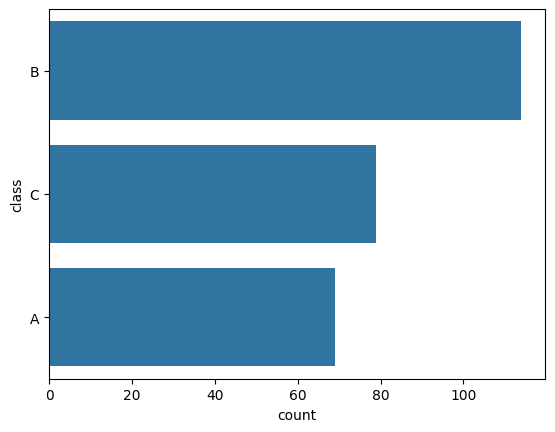

In [ ]:
#class imbalanced -> Oversampling 적용
sns.countplot(train_y)

## Data Pre-processing

In [ ]:
train_x = train_x.drop(columns=['father','mother','gender'])
test_x = test_x.drop(columns=['father','mother','gender'])

## Feature Engineering

In [ ]:
snp

,SNP_id,name,chrom,cm,pos
0,SNP_01,BTA-19852-no-rs,2,67.05460,42986890
1,SNP_02,ARS-USMARC-Parent-DQ647190-rs29013632,6,31.15670,13897068
2,SNP_03,ARS-BFGL-NGS-117009,6,68.28920,44649549
3,SNP_04,ARS-BFGL-NGS-60567,6,77.87490,53826064
4,SNP_05,BovineHD0600017032,6,80.50150,61779512
5,SNP_06,BovineHD0600017424,6,80.59540,63048481
6,SNP_07,Hapmap49442-BTA-111073,6,80.78000,64037334
7,SNP_08,BovineHD0600018638,6,82.68560,67510588
8,SNP_09,ARS-BFGL-NGS-37727,6,86.87400,73092782
9,SNP_10,BTB-01558306,7,62.06920,40827112


*SNP 정보(name, chrom, cm, pos)를 활용하여 Feature Engineering을 진행하였습니다

1. name(SNP 명) & chrom(염색체 정보)
2. chrom(염색체 정보)
3. SNP Total combination
4. cm(Genetic distance)
5. SNP G,C,A mathematical feature

#### SNP 합

In [ ]:
train_x['2_BTA'] = train_x['SNP_01']
train_x['chrom_6'] = train_x['SNP_02'] + '-'+ train_x['SNP_03'] + '-' + train_x['SNP_04'] + '-' + train_x['SNP_05'] + '-' + train_x['SNP_06'] + '-' + train_x['SNP_07'] + '-' + train_x['SNP_08'] + '-' + train_x['SNP_09']
train_x['6_ARS_Parent'] = train_x['SNP_02']
train_x['6_ARS_BFGL'] = train_x['SNP_03'] + '-' + train_x['SNP_04'] + '-' + train_x['SNP_09']
train_x['6_BOVINE'] = train_x['SNP_05'] + '-' + train_x['SNP_06'] + '-' + train_x['SNP_08']
train_x['6_HAPMAP'] = train_x['SNP_07']
train_x['7_BTB'] = train_x['SNP_10']
train_x['8_ARS'] = train_x['SNP_11']
train_x['chrom_9'] = train_x['SNP_12'] + '-' + train_x['SNP_13'] + '-' + train_x['SNP_14']
train_x['9_HAPMAP'] = train_x['SNP_12'] + '-' + train_x['SNP_14']
train_x['9_BTB'] = train_x['SNP_13']
train_x['10_BOVINE'] = train_x['SNP_15']
train_x['SNP_total'] = train_x['SNP_01'] + '-' + train_x['SNP_02'] + '-' + train_x['SNP_03'] + '-' + train_x['SNP_04'] + '-' + train_x['SNP_05'] + '-' + train_x['SNP_06'] + '-' + train_x['SNP_07'] + '-' + train_x['SNP_08'] + '-' + train_x['SNP_09'] + '-' + train_x['SNP_10'] + '-' + train_x['SNP_11'] + '-' + train_x['SNP_12'] + '-' + train_x['SNP_13'] + '-' + train_x['SNP_14'] + '-' + train_x['SNP_15']

In [ ]:
test_x['2_BTA'] = test_x['SNP_01']
test_x['chrom_6'] = test_x['SNP_02'] + '-'+ test_x['SNP_03'] + '-' + test_x['SNP_04'] + '-' + test_x['SNP_05'] + '-' + test_x['SNP_06'] + '-' + test_x['SNP_07'] + '-' + test_x['SNP_08'] + '-' + test_x['SNP_09']
test_x['6_ARS_Parent'] = test_x['SNP_02']
test_x['6_ARS_BFGL'] = test_x['SNP_03'] + '-' + test_x['SNP_04'] + '-' + test_x['SNP_09']
test_x['6_BOVINE'] = test_x['SNP_05'] + '-' + test_x['SNP_06'] + '-' + test_x['SNP_08']
test_x['6_HAPMAP'] = test_x['SNP_07']
test_x['7_BTB'] = test_x['SNP_10']
test_x['8_ARS'] = test_x['SNP_11']
test_x['chrom_9'] = test_x['SNP_12'] + '-' + test_x['SNP_13'] + '-' + test_x['SNP_14']
test_x['9_HAPMAP'] = test_x['SNP_12'] + '-' + test_x['SNP_14']
test_x['9_BTB'] = test_x['SNP_13']
test_x['10_BOVINE'] = test_x['SNP_15']
test_x['SNP_total'] = test_x['SNP_01'] + '-' + test_x['SNP_02'] + '-' + test_x['SNP_03'] + '-' + test_x['SNP_04'] + '-' + test_x['SNP_05'] + '-' + test_x['SNP_06'] + '-' + test_x['SNP_07'] + '-' + test_x['SNP_08'] + '-' + test_x['SNP_09'] + '-' + test_x['SNP_10'] + '-' + test_x['SNP_11'] + '-' + test_x['SNP_12'] + '-' + test_x['SNP_13'] + '-' + test_x['SNP_14'] + '-' + test_x['SNP_15']

#### 공백제거

In [ ]:
def blank(data_tr, data_te, columns):
    for i in columns :
        data_tr[i] = data_tr[i].apply(lambda x : x.replace(" ",""))
        data_te[i] = data_te[i].apply(lambda x : x.replace(" ",""))

    return data_tr, data_te

target_columns = train_x.iloc[:,16:].columns.to_list()
train_x.iloc[:,16:], test_x.iloc[:,16:] = blank(train_x.iloc[:,16:], test_x.iloc[:,16:], target_columns)

#### SNP A,C,G 값 개수

In [ ]:
train_x['concat'] = train_x.iloc[:,1:16].sum(axis=1).apply(lambda x : x.replace(" ",""))
train_x['numGC'] = train_x['concat'].apply(lambda x : x.count('C')+x.count('G'))
train_x['numA'] = train_x['concat'].apply(lambda x : x.count('A'))
train_x['numGC^2'] = train_x['numGC']**2
train_x['sub'] = train_x['numGC'] - train_x['numA']
train_x['H'] = train_x['numGC']*3 + train_x['numA']*2

In [ ]:
test_x['concat'] = test_x.iloc[:,1:16].sum(axis=1).apply(lambda x : x.replace(" ",""))
test_x['numGC'] = test_x['concat'].apply(lambda x : x.count('C')+x.count('G'))
test_x['numA'] = test_x['concat'].apply(lambda x : x.count('A'))
test_x['numGC^2'] = test_x['numGC']**2
test_x['sub'] = test_x['numGC'] - test_x['numA']
test_x['H'] = test_x['numGC']*3 + test_x['numA']*2

#### trait 변수 type 변환

In [ ]:
train_x['trait'] = train_x['trait'].astype('object')
test_x['trait'] = test_x['trait'].astype('object')

#### 범주형, 수치형 피처 구분

In [ ]:
cat_features = train_x.select_dtypes(include=['object']).columns.to_list()
num_features = train_x.select_dtypes(exclude=['object']).columns.to_list()

## Scaling

In [ ]:
scaler = StandardScaler()
train_x[num_features] = scaler.fit_transform(train_x[num_features])
test_x[num_features] = scaler.transform(test_x[num_features])

## Encoding

In [ ]:
def catboost_encoder_multiclass(X,X_t,y):
    y = y.astype(str)
    enc = ce.OneHotEncoder().fit(y)
    y_onehot = enc.transform(y)
    class_names = y_onehot.columns
    X_obj = X.select_dtypes('object')
    X_t_obj = X_t.select_dtypes('object')
    X = X.select_dtypes(exclude='object')
    X_t = X_t.select_dtypes(exclude='object')
    for class_ in class_names:
        enc = ce.CatBoostEncoder()
        enc.fit(X_obj,y_onehot[class_])
        temp = enc.transform(X_obj)
        temp_t = enc.transform(X_t_obj)
        temp.columns = [str(x)+'_'+str(class_) for x in temp.columns]
        temp_t.columns = [str(x)+'_'+str(class_) for x in temp_t.columns]
        X = pd.concat([X,temp],axis=1)
        X_t = pd.concat([X_t,temp_t],axis=1)

    return X, X_t

train_x, test_x = catboost_encoder_multiclass(train_x,test_x,train_y)

## SMOTE

In [ ]:
# Class 불균형 문제 해결
train_x,train_y = BorderlineSMOTE(random_state=CFG.SEED).fit_resample(train_x,train_y)

## Target Label-Encoding

In [ ]:
class_le = LabelEncoder()
train_y = class_le.fit_transform(train_y)

## Modeling & Ensemble

In [ ]:
submit = pd.read_csv(DATA_PATH  + 'sample_submission.csv')

In [ ]:
import sys, os, os.path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pickle

import h2o
from h2o.automl import H2OAutoML

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import os
import numpy as np

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier



Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.27" 2025-04-15; OpenJDK Runtime Environment (build 11.0.27+6-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.27+6-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpkvldpiu5
  JVM stdout: /tmp/tmpkvldpiu5/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpkvldpiu5/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,1 month and 10 days
H2O_cluster_name:,H2O_from_python_unknownUser_cdry38
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,12 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
!pip install h2o

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 MB 4.9 MB/s eta 0:00:00


In [ ]:
import h2o
from h2o.automl import H2OAutoML
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
h2o.init()

aml = H2OAutoML(
    max_runtime_secs=60,
    seed=42,
    stopping_metric='AUTO',
    project_name='h2o_automl_demo'
)
train_x_, test_x_, train_y_, test_y_ = train_test_split(train_x, train_y, test_size=0.2, random_state=42)


train_df = pd.DataFrame(train_x_)
train_df['target'] = train_y_
test_df = pd.DataFrame(test_x_)
test_df['target'] = test_y_

train_h2o = h2o.H2OFrame(train_df)
test_h2o = h2o.H2OFrame(test_df)

x_cols = train_h2o.columns[:-1]
y_col = 'target'

train_h2o[y_col] = train_h2o[y_col].asfactor()
test_h2o[y_col] = test_h2o[y_col].asfactor()
aml.train(x=x_cols, y=y_col, training_frame=train_h2o)

lb = aml.leaderboard

pred_test_h2o = aml.leader.predict(test_h2o)
pred_test = pred_test_h2o.as_data_frame()['predict']

acc = accuracy_score(test_y_, pred_test)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,3 mins 41 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,1 month and 11 days
H2O_cluster_name:,H2O_from_python_unknownUser_cdry38
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.169 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |████████████████████████
06:28:22.859: GBM_1_AutoML_1_20250509_62759 [GBM def_5] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_1_AutoML_1_20250509_62759.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 189.0.
ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 189.0.
ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 190.0.
ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)



In [ ]:
  #최종모델은 Votingclassifier 사용하여 ensemble -> 제출결과 public score기준 XGBClassifier와 RandomForestClassifier 성능이 좋아 가중치를 주었음
best_model  = VotingClassifier(models, voting='hard', weights=[1,1,1,2,1,1,1,1,2])
best_model.fit(train_x,train_y)

VotingClassifier(estimators=[('bag', BaggingClassifier(random_state=26)),
                             ('dt', DecisionTreeClassifier(random_state=26)),
                             ('rc', RidgeClassifier(random_state=26)),
                             ('xgb', XGBClassifier(random_state=26)),
                             ('lgb', LGBMClassifier(random_state=26)),
                             ('gb',
                              GradientBoostingClassifier(random_state=26)),
                             ('svc', SVC(random_state=26)),
                             ('rcc',
                              RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]))),
                             ('rf', RandomForestClassifier(random_state=26))],
                 weights=[1, 1, 1, 2, 1, 1, 1, 1, 2])

## Submit

In [ ]:
test_h2o = h2o.H2OFrame(test_x)

pred_h2o = aml.leader.predict(test_h2o)
pred = pred_h2o.as_data_frame()['predict']

pred_decoded = class_le.inverse_transform(pred.astype(int))

submit['class'] = pred_decoded

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)



In [ ]:
submit

,id,class
0,TEST_000,A
1,TEST_001,B
2,TEST_002,C
3,TEST_003,B
4,TEST_004,A
...,...,...
170,TEST_170,B
171,TEST_171,C
172,TEST_172,C
173,TEST_173,B


In [ ]:
submit.to_csv('Fine_20.csv',index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')